In [1]:
import sys
import os
import numpy as np
import napari
%matplotlib inline
from matplotlib import pyplot as plt  # graphic library, for plots
import numba as nb
import tifffile
import skimage

In [2]:
import filedialogs

In [3]:
from metavision_core.event_io.raw_reader import RawReader
from metavision_core.event_io.py_reader import EventDatReader
from metavision_core.event_io import EventsIterator
from metavision_sdk_cv import ActivityNoiseFilterAlgorithm

### Loading Datasets

In [ ]:
#path = filedialogs.gui_fname('example_data/')
#path = path.decode('ascii')

In [6]:
path = 'C:/Users/B0067-WS-2/Documents/code/github-ffvoigt/accordion/playground/example_data/recording_2023-07-04_16-04-32.raw'

In [7]:
record_raw = RawReader(path, max_events=100000000)
print(record_raw)

RawReader(C:/Users/B0067-WS-2/Documents/code/github-ffvoigt/accordion/playground/example_data/recording_2023-07-04_16-04-32.raw)
current time : 0us done : False
current event index : 0
_begin_buffer 0,_end_buffer_ 0,  buffer_size 100000000


In [8]:
events = record_raw.load_n_events(90000000)
print('Start Time:  ', events['t'][0]/1000, ' ms')
print('End Time:    ', events['t'][-1]/1000, ' ms')
print('Total Events:', len(events))

Start Time:   6.547  ms
End Time:     5654.423  ms
Total Events: 1586750


In [63]:
events

array([(555, 119, 0,    6547), (361, 306, 1,    6559),
       (586,  87, 1,    6566), ..., (579, 673, 0, 5654361),
       (579, 673, 0, 5654362), (361, 306, 1, 5654423)],
      dtype={'names': ['x', 'y', 'p', 't'], 'formats': ['<u2', '<u2', '<i2', '<i8'], 'offsets': [0, 2, 4, 8], 'itemsize': 16})

### Noise filtering
For whatever reason: If `filtered_events_` and `filtered_events` are the same variable, the export doesn't work

In [ ]:
'''
print('Started with: ', len(events),' events' )
noisereductionfilter = ActivityNoiseFilterAlgorithm(1280,720,1000)
filtered_events_ = noisereductionfilter.get_empty_output_buffer()
noisereductionfilter.process_events(events, filtered_events_)
filtered_events = filtered_events_.numpy()
print('After filtering: ', len(filtered_events),' events' )
'''

In [9]:
filtered_events = events

### Quick visualization

In [10]:
def viz_events(events, height, width):
    img = np.full((height, width, 3), 128, dtype=np.uint8)
    img[events['y'], events['x']] = 255 * events['p'][:, None]
    return img

In [11]:
len(events)

1586750

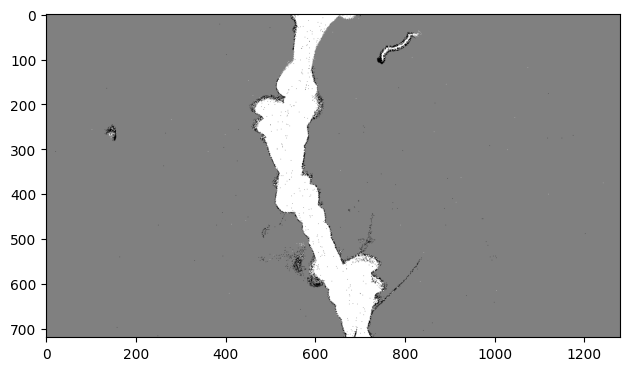

In [13]:
height, width = record_raw.get_size()
im = viz_events(events[], height, width)
plt.imshow(im)
plt.tight_layout()

### Conversion to image-like array
* 8bit, Z or T, X, Y, C 
* e.g. np.random.randint(0, 255, (100, 720, 1280, 3), 'uint8')

In [64]:
@nb.njit
def events_to_stack(events, dt=1000, imagesize=(720, 1280)):
    height, width = imagesize
    min_timepoint = events['t'].min()
    max_timepoint = events['t'].max()
    
    timepoints = int(np.ceil((max_timepoint - min_timepoint)/dt))    
    
    # generate a numpy array with the width 
    eventstack = np.zeros((timepoints,height,width,2), dtype='uint8')
    
    for event in events:
        x_pos = event[1]
        y_pos = event[0]
        timepoint = np.floor_divide((event[3]-min_timepoint),dt)
        if event[2] == 0:
            if eventstack[timepoint, x_pos, y_pos, 0] < 255:
                eventstack[timepoint, x_pos, y_pos, 0] += 1
        else: 
            if eventstack[timepoint, x_pos, y_pos, 1] < 255:
                eventstack[timepoint, x_pos, y_pos, 1] += 1
             
    
    return eventstack 

In [65]:
eventstack = events_to_stack(events, dt=1000)
print('Size of the eventstack in GB: ', eventstack.size/8/1024/1024/1024)

Size of the eventstack in GB:  1.2119293212890625


In [66]:
eventstack.shape

(5648, 720, 1280, 2)

In [67]:
np.max(eventstack)

27

In [86]:
eventstack_crop = eventstack[:,150:600,460:690,:]

In [50]:
#eventstack_crop = eventstack[2180:2489,150:600,0:220,:]

In [87]:
print('Size of the cropped eventstack in GB: ', eventstack_crop.size/8/1024/1024/1024)

Size of the cropped eventstack in GB:  0.13610534369945526


In [88]:
np.max(eventstack_crop)

4

In [94]:
eventstack_crop2 = eventstack_crop[2200:2440]

### Napari visualization

In [84]:
viewer = napari.Viewer()

In [97]:
my_new_layer = viewer.add_image(eventstack_crop2, channel_axis=3, contrast_limits=[[0,3],[0,3]], name=['ON Events', 'Off Events'])

Rendering frames...


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:06<00:00, 19.02it/s]


Rendering frames...


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:05<00:00, 22.08it/s]


Rendering frames...


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:03<00:00, 21.69it/s]


Rendering frames...


100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:04<00:00, 21.93it/s]


Rendering frames...


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:04<00:00, 18.37it/s]


Rendering frames...


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:04<00:00, 18.19it/s]


Rendering frames...


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:04<00:00, 17.89it/s]


Rendering frames...


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:04<00:00, 17.79it/s]


Rendering frames...


100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:04<00:00, 18.05it/s]


Rendering frames...


100%|██████████████████████████████████████████████████████████████████████████████| 1501/1501 [01:18<00:00, 19.09it/s]


Rendering frames...


100%|██████████████████████████████████████████████████████████████████████████████| 1501/1501 [01:17<00:00, 19.37it/s]


### Exporting data

In [35]:
on_events = eventstack_crop[:,:,:,1]

In [36]:
off_events = eventstack_crop[:,:,:,0]

In [ ]:
on_events.size

In [37]:
tifffile.imwrite('pigmented_fish_on_events.tif', on_events, photometric='minisblack')
tifffile.imwrite('pigmented_fish_off_events.tif', off_events, photometric='minisblack')